c:\Users\pmarc\.conda\envs\inteli_cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset size: 12800
Image shape: torch.Size([1, 21, 21])


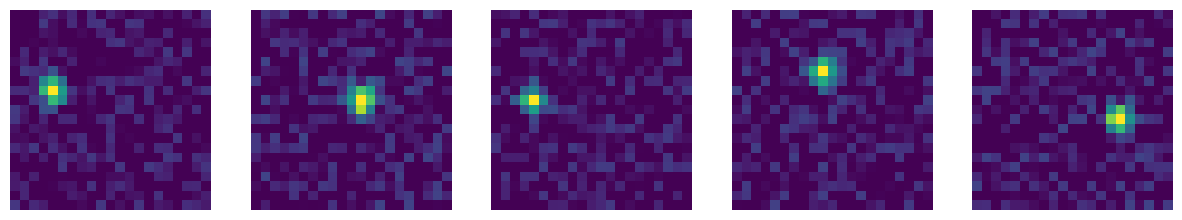

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.metrics as metrics
import src.model.train as train
import src.model.ae as ae
import src.model.gau as gaussian
import src.model.linear_probing as lp
import src.plots as plots


In [4]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')

In [5]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

Dataset size: 12800
Image shape: torch.Size([1, 21, 21])


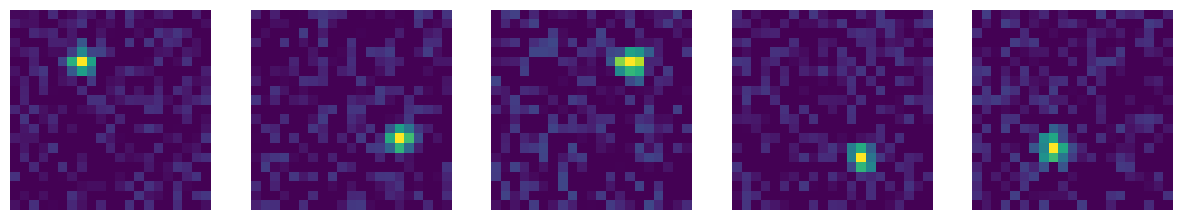

In [6]:
importlib.reload(gaussian)

# generate fake gaussian dataset
num_samples = 15000
image_size = 21
border_margin = 4
noise_level = 0.1
brightness = 0.7

gaussian_images = gaussian.generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)
gaussian_dataset = TensorDataset(gaussian_images)

In [7]:
train_dataset_0 = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_dataset_0 = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_dataset_0 = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

#normalize between 0 and 1
train_difference = (train_dataset_0 - train_dataset_0.min()) / (train_dataset_0.max() - train_dataset_0.min())
validation_difference = (validation_dataset_0 - validation_dataset_0.min()) / (validation_dataset_0.max() - validation_dataset_0.min())
test_difference = (test_dataset_0 - test_dataset_0.min()) / (test_dataset_0.max() - test_dataset_0.min())

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

train_dataset_0 = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset_0 = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset_0 = TensorDataset(reshaped_test_difference, reshaped_test_class)

In [8]:
train_difference = torch.tensor(dataset_1_21['Train']['images'], dtype=torch.float32)
validation_difference = torch.tensor(dataset_1_21['Validation']['images'], dtype=torch.float32)
test_difference = torch.tensor(dataset_1_21['Test']['images'], dtype=torch.float32)

train_class_1 = torch.tensor(dataset_1_21['Train']['class'], dtype=torch.float32)
validation_class_1 = torch.tensor(dataset_1_21['Validation']['class'], dtype=torch.float32)
test_class_1 = torch.tensor(dataset_1_21['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Seleccionar los canales 0 y 2
train_difference_reshaped = train_difference[:, :, :, [0, 2]]
validation_difference_reshaped = validation_difference[:, :, :, [0, 2]]
test_difference_reshaped = test_difference[:, :, :, [0, 2]]

# Permutar las dimensiones para que tengan la forma [batch_size, num_channels, height, width]
train_difference_reshaped_perm = train_difference_reshaped.permute(0, 3, 1, 2)
validation_difference_reshaped_perm = validation_difference_reshaped.permute(0, 3, 1, 2)
test_difference_reshaped_perm = test_difference_reshaped.permute(0, 3, 1, 2)

train_dataset_1 = TensorDataset(train_difference_reshaped_perm, train_class_1)
validation_dataset_1 = TensorDataset(validation_difference_reshaped_perm, validation_class_1)
test_dataset_1 = TensorDataset(test_difference_reshaped_perm, test_class_1)

In [9]:
test_model_1 = ae.AE(latent_dim=30, n_channels=2, name='test_model_1')
test_model_2 = ae.AE(latent_dim=30, n_channels=2, name='test_model_2')
test_model_3 = ae.AE(latent_dim=30, n_channels=2, name='test_model_3')

test_model_1.load_state_dict(torch.load('models/model_1_1.pth'))
test_model_1.eval()

test_model_2.load_state_dict(torch.load('models/model_1_2.pth'))
test_model_2.eval()

test_model_3.load_state_dict(torch.load('models/model_1_3.pth'))
test_model_3.eval()

test_models = [test_model_1, test_model_2, test_model_3]

C:\Users\pmarc\AppData\Local\Temp\ipykernel_21404\2678627918.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_1.load_state_dict(torch.load('models/model_1_1.pt

In [10]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 0.333e-4
use_gpu = True

In [11]:
importlib.reload(lp)

train_1, val_1, test_1 = lp.get_latent_features(test_models, train_dataset_1, validation_dataset_1, test_dataset_1)

lp_model_1_1 = lp.LinearClassifier(42, 5)
lp_model_1_2 = lp.LinearClassifier(42, 5)
lp_model_1_3 = lp.LinearClassifier(42, 5)

lp_curves_1_1, lp_tiempo_1_1, lp_labels_1_1, lp_pred_1_1 = lp.train_model(lp_model_1_1, train_1[0], val_1[0], test_1[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_2, lp_tiempo_1_2, lp_labels_1_2, lp_pred_1_2 = lp.train_model(lp_model_1_2, train_1[1], val_1[1], test_1[1], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_3, lp_tiempo_1_3, lp_labels_1_3, lp_pred_1_3 = lp.train_model(lp_model_1_3, train_1[2], val_1[2], test_1[2], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

lp_models_1 = [lp_model_1_1, lp_model_1_2, lp_model_1_3]
matrix_1 = [confusion_matrix(lp_labels_1_1, lp_pred_1_1), confusion_matrix(lp_labels_1_2, lp_pred_1_2), confusion_matrix(lp_labels_1_3, lp_pred_1_3)]

KeyboardInterrupt: 

In [ ]:
# settings

#umap 
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

In [ ]:
metrics.plot_umap(test_models, test_dataset_1, test_class_1, n_neighbors, min_dist, metric, norm)

In [ ]:
metrics.plot_matrix(test_models, matrix_1)
metrics.plot_umap(lp_models_1, val_1, n_neighbors, min_dist, metric, norm)

In [ ]:
plots.plot_example(test_models, test_dataset_1)